In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import umap

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from models.pipeline import Pipeline

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=128,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_128_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [ ]:
model = ConvolutionalVQVAE(
    in_channels=10, 
    starting_filters=64, 
    num_embeddings=256,
    embedding_dim=64,
    commitment_cost=0.25
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vqvae_6x6x64_b2.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq,
    postprocess_fn=postprocess_vq,
)
model_type = "vq"

In [3]:
input_dim = 6*6*64
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/vq_vae_64_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_vq_into_vae_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b2.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq_into_vae,
    postprocess_fn=postprocess_vq_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [ ]:

n_components = 128

input_dim = n_components
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/ppca128_vae_64_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_ppca_into_vae_compresison_functions(f'../../checkpoints/ppca_{n_components}.pkl')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_ppca_into_vae,
    postprocess_fn=postprocess_ppca_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [5]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [ ]:
def display_task_latent_space(puzzle_id, data, pipeline: Pipeline, visualisation_type='umap'):
    task_train_grid_pairs = data[puzzle_id]['train']
    task_test_grid_pair = data[puzzle_id]['test'][0]

    other_grid_pairs = [
        pair
        for pid, task in data.items()
        if pid != puzzle_id
        for split in ['train', 'test']
        for pair in task[split]
    ]

    batch_size = 1
    task_train_loader = pipeline.create_data_loader(task_train_grid_pairs, batch_size=batch_size, shuffle=False)
    task_test_loader = pipeline.create_data_loader([task_test_grid_pair], batch_size=batch_size, shuffle=False)
    other_loader = pipeline.create_data_loader(other_grid_pairs, batch_size=batch_size, shuffle=False)

    def get_latents(loader):
        z = []
        for (input, output) in loader:
            with torch.no_grad():
                # VAE
                z_mu, _ = pipeline.encode(input.to(device))
                z.append(z_mu)
                z_mu, _ = pipeline.encode(output.to(device))
                z.append(z_mu)

                # VQVAE
                # z_e = pipeline.encode(input.to(device))
                # z_flat = z_e.permute(0, 2, 3, 1).reshape(-1, z_e.shape[1])
                # z.append(z_flat)
                # z_e = pipeline.encode(output.to(device))
                # z_flat = z_e.permute(0, 2, 3, 1).reshape(-1, z_e.shape[1])
                # z.append(z_flat)
                        
        return z

    z_train = get_latents(task_train_loader)
    z_test = get_latents(task_test_loader)
    z_other = get_latents(other_loader)

    z = z_train + z_test + z_other
    z = torch.cat(z, dim=0) 
    z_np = z.detach().cpu().numpy()

    latent_2d = None
    if visualisation_type == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
        latent_2d = reducer.fit_transform(z_np)
    elif visualisation_type == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        latent_2d = tsne.fit_transform(z_np)

    # num_train = len(z_train)
    # num_test = len(z_test)
    num_train = len(z_train) // 2
    num_test = len(z_test) // 2

    start = 0
    train_input_2d = latent_2d[start:start + num_train]
    train_output_2d = latent_2d[start + num_train:start + 2 * num_train]

    start += 2 * num_train
    test_input_2d = latent_2d[start:start + num_test]
    test_output_2d = latent_2d[start + num_test:start + 2 * num_test]

    start += 2 * num_test
    other_latents_2d = latent_2d[start:]

    x_range = latent_2d[:, 0].max() - latent_2d[:, 0].min()
    y_range = latent_2d[:, 1].max() - latent_2d[:, 1].min()
    scale = (x_range + y_range) / 2

    
    plt.figure(figsize=(10, 8))

    arrow_head_width = 0.01 * scale 
    arrow_head_length = 0.015 * scale

    for i in range(num_train):
        plt.arrow(train_input_2d[i, 0], train_input_2d[i, 1],
                train_output_2d[i, 0] - train_input_2d[i, 0],
                train_output_2d[i, 1] - train_input_2d[i, 1],
                color='black', alpha=0.8, 
                head_width=arrow_head_width,
                head_length=arrow_head_length,
                length_includes_head=True)

    for i in range(num_test):
        plt.arrow(test_input_2d[i, 0], test_input_2d[i, 1],
                test_output_2d[i, 0] - test_input_2d[i, 0],
                test_output_2d[i, 1] - test_input_2d[i, 1],
                color='black', alpha=0.8, 
                head_width=arrow_head_width,
                head_length=arrow_head_length, 
                length_includes_head=True)

    plt.scatter(other_latents_2d[:, 0], other_latents_2d[:, 1], color='gray', alpha=0.3, s=10, label=None)

    plt.scatter(train_input_2d[:, 0], train_input_2d[:, 1], color='blue', s=15, label='Train Input')
    plt.scatter(train_output_2d[:, 0], train_output_2d[:, 1], color='red', s=15, label='Train Output')
    plt.scatter(test_input_2d[:, 0], test_input_2d[:, 1], color='black', s=20, label='Test Input')
    plt.scatter(test_output_2d[:, 0], test_output_2d[:, 1], color='limegreen', s=20, label='Test Output')

    plt.title(f"Task {puzzle_id}: Latent Space Projection ({visualisation_type.upper()})")
    plt.legend()
    plt.tight_layout()
    plt.show()

/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/l

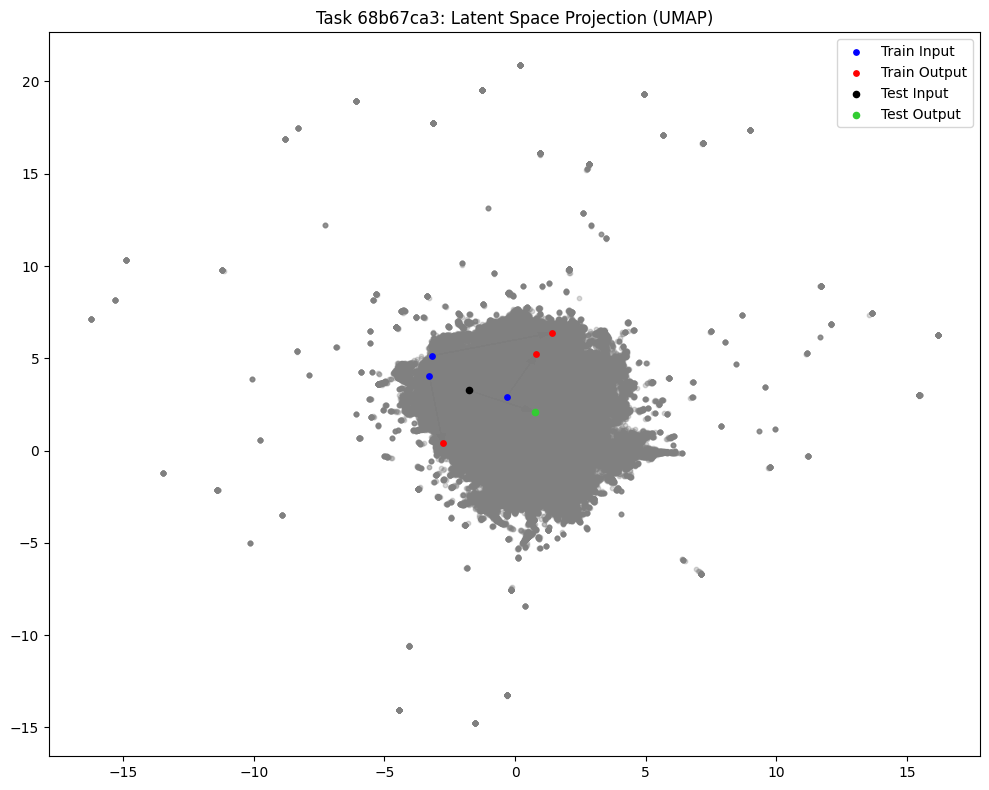

KeyboardInterrupt: 

In [6]:
task_ids = ['68b67ca3', 'e872b94a', 'd4b1c2b1']
for task_id in task_ids:
    display_task_latent_space(task_id, data, pipeline, visualisation_type='umap')
    display_task_latent_space(task_id, data, pipeline, visualisation_type='tsne')


In [4]:
import torch.nn.functional as F
from utils.view import draw_grid

def interpolate_between_samples(pipeline: Pipeline, input, output, num_steps=10):
    x_out = []
    with torch.no_grad():
        for i in range(output.shape[0]):
            x1 = input[i].unsqueeze(0).to(device)
            x2 = output[i].unsqueeze(0).to(device)

            # Take only the first sample in each batch
            x1 = x1[0].unsqueeze(0).to(device)
            x2 = x2[0].unsqueeze(0).to(device)

            mu1, _ = pipeline.encode(x1)
            mu2, _ = pipeline.encode(x2)

            z_interp = torch.stack([
                torch.lerp(mu1, mu2, t) for t in torch.linspace(0, 1, num_steps).to(device)
            ])  # shape: (num_steps, 128)

            # TODO estimate output dimensions
            out = pipeline.decode(z_interp)
            out = torch.argmax(F.softmax(out, dim=1), dim=1)  # if output is logits over classes
            x_out.append(out.cpu().squeeze())

    for i in range(len(x_out)):
        # Plotting
        fig, axes = plt.subplots(1, num_steps, figsize=(15, 6))
        for step in range(num_steps):
            draw_grid(axes[step], x_out[i][step])
        plt.suptitle("Interpolation in Latent Space")
        plt.show()


# for _, (input,output) in enumerate(data_loader):
    # interpolate_between_samples(model, input, output, num_steps=5)

In [6]:
pairs = [pair for task in data.values() for pairs in task.values() for pair in pairs]

data_loader = pipeline.create_data_loader(pairs, batch_size=1, shuffle=False)

all_latents_mu = []
all_latents_logvar = []

# for (input, output) in data_loader:
#     mu, logvar = pipeline.encode(input.to(device))
#     all_latents_mu.append(mu)
#     all_latents_logvar.append(logvar)

#     mu, logvar = pipeline.encode(output.to(device))
#     all_latents_mu.append(mu)
#     all_latents_logvar.append(logvar)

# # Concatenate all the mu and logvar values
# latents_mu = torch.cat(all_latents_mu, dim=0)
# latents_logvar = torch.cat(all_latents_logvar, dim=0)

# # Calculate the mean and std for mu
# mean_vector_mu = latents_mu.mean(dim=0)
# std_vector_mu = latents_mu.std(dim=0)

# # Calculate the mean and std for logvar (log of variance)
# mean_vector_logvar = latents_logvar.mean(dim=0)
# std_vector_logvar = latents_logvar.std(dim=0)

# overall_mean_mu = mean_vector_mu.mean()
# overall_mean_logvar = mean_vector_logvar.mean()

# # print("Mean per dimension for mu:", mean_vector_mu)
# print("Overall mean for mu:", overall_mean_mu.item())

# # print("Std per dimension for mu:", std_vector_mu)
# print("Average std for mu:", std_vector_mu.mean().item())

# # print("Mean per dimension for logvar:", mean_vector_logvar)
# print("Overall mean for logvar:", overall_mean_logvar.item())

# # print("Std per dimension for logvar:", std_vector_logvar)
# print("Average std for logvar:", std_vector_logvar.mean().item())

In [8]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import hdbscan

import matplotlib.cm as cm

def produce_latent(pipeline: Pipeline, grid, model_type="vq"):
    z = grid
    if model_type == 'vae':
        grid = grid.squeeze(0)
        z_mu, _ = pipeline.encode(grid.to(device))
        # z_mu = z_mu.unsqueeze(0)
        z = z_mu
    else:
        z_e = pipeline.encode(grid.to(device))
        z_avg = z_e.mean(dim=[2, 3])
        z = z_avg
    
    return z
        

z = []
for (input, output) in data_loader:
    with torch.no_grad():
        z.append(produce_latent(pipeline, input, model_type))
        z.append(produce_latent(pipeline, output, model_type))
        
z = torch.cat(z, dim=0)  # shape [2*N, latent_dim]
z_np = z.detach().cpu().numpy()
print(z_np.shape)
z_scaled = StandardScaler().fit_transform(z_np)

def visualise_clusters(z, clustering_type, visualisation_type):    
    labels = None
    
    if clustering_type == 'kmeans':
        labels = KMeans(n_clusters=3).fit_predict(z)
    elif clustering_type == 'gmm':
        labels = GaussianMixture(n_components=2).fit_predict(z)
    elif clustering_type == 'dbscan':
        labels = DBSCAN(eps=2, min_samples=5).fit_predict(z)
    elif clustering_type == 'hdbscan':
        labels = hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(z)

    latent_2d = None
    if visualisation_type == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
        latent_2d = reducer.fit_transform(z)  # shape: [2*N, 2]
    elif visualisation_type == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        latent_2d = tsne.fit_transform(z)

    num_clusters = len(np.unique(labels))
    cmap = cm.get_cmap('tab10', num_clusters)
    colors = [cmap(l) for l in labels]

    # Plot all points together
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=10)
    plt.title(f"Latent Space ({visualisation_type.upper()} + {clustering_type.upper()} Clusters)")
    plt.tight_layout()
    plt.show()

(3564, 64)


/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_87859/712093697.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_clusters)


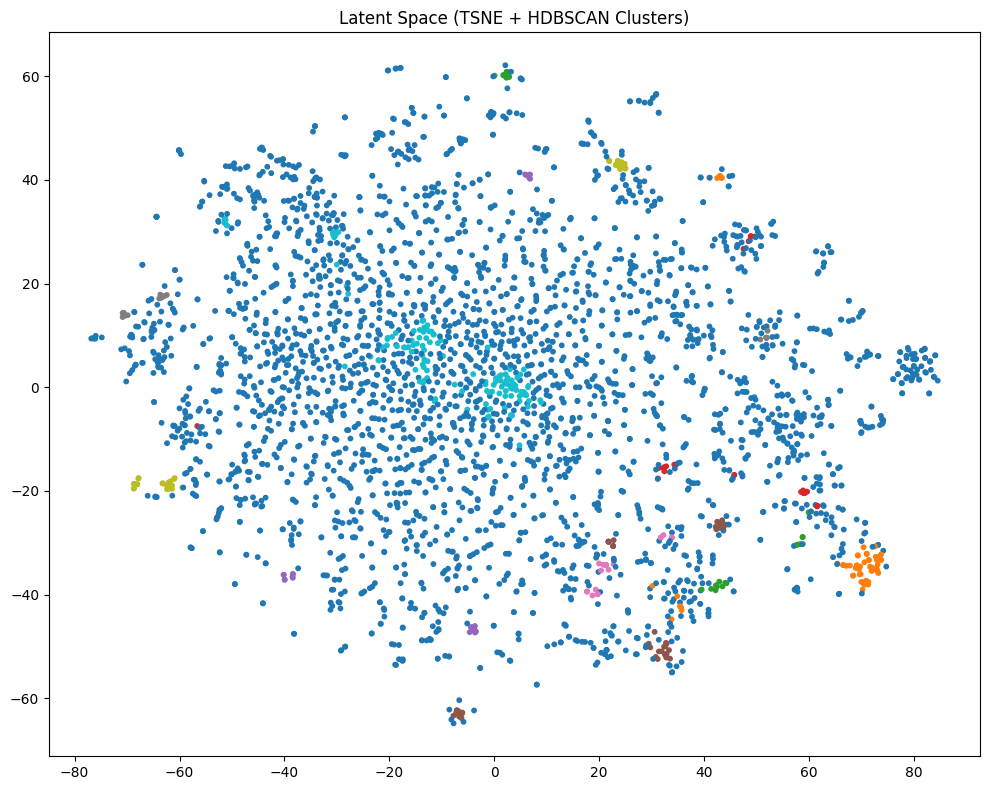

/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
O

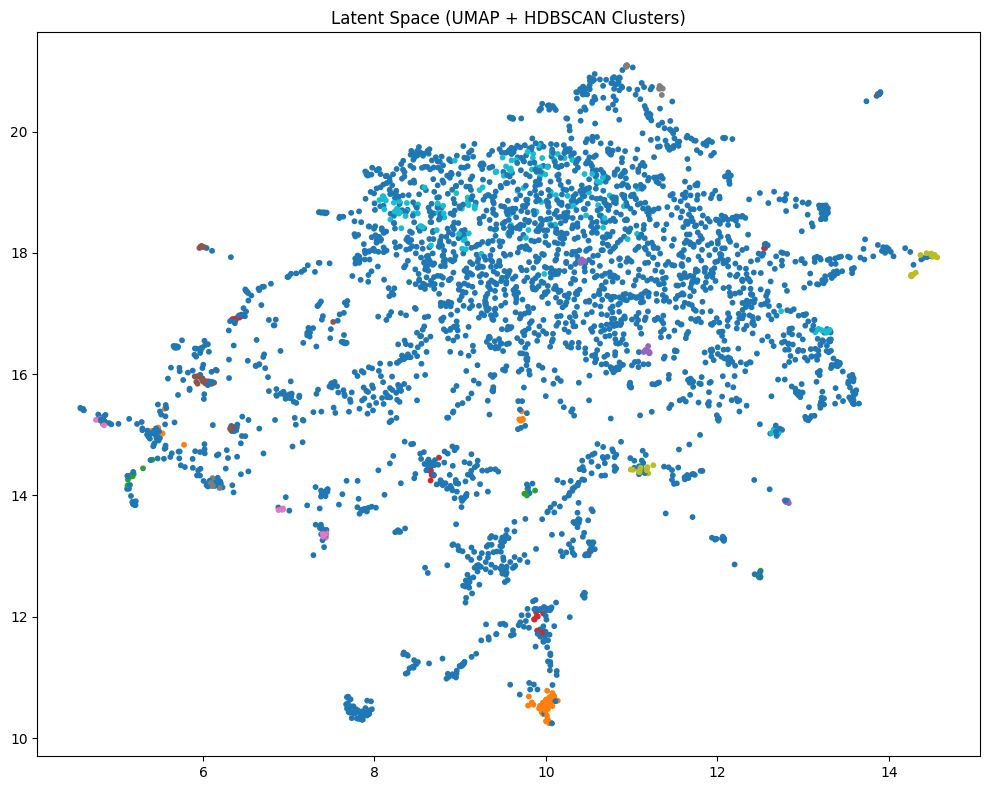

In [9]:
# visualise_clusters(z_scaled, clustering_type='kmeans', visualisation_type='tsne')
# visualise_clusters(z_scaled, clustering_type='gmm', visualisation_type='tsne')
# visualise_clusters(z_scaled, clustering_type='dbscan', visualisation_type='tsne')
# visualise_clusters(z_scaled, clustering_type='kmeans', visualisation_type='tsne')
# visualise_clusters(z_scaled, clustering_type='kmeans', visualisation_type='umap')
visualise_clusters(z_scaled, clustering_type='hdbscan', visualisation_type='tsne')
visualise_clusters(z_scaled, clustering_type='hdbscan', visualisation_type='umap')

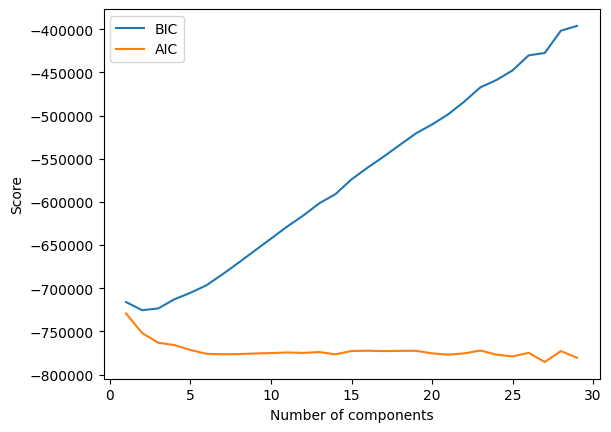

In [25]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

size = 30
bics = []
aics = []

for n_components in range(1, size): 
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(z_np)
    bics.append(gmm.bic(z_np))
    aics.append(gmm.aic(z_np))

plt.plot(range(1, size), bics, label='BIC')
plt.plot(range(1, size), aics, label='AIC')
plt.legend()
plt.xlabel('Number of components') 
plt.ylabel('Score')
plt.show()

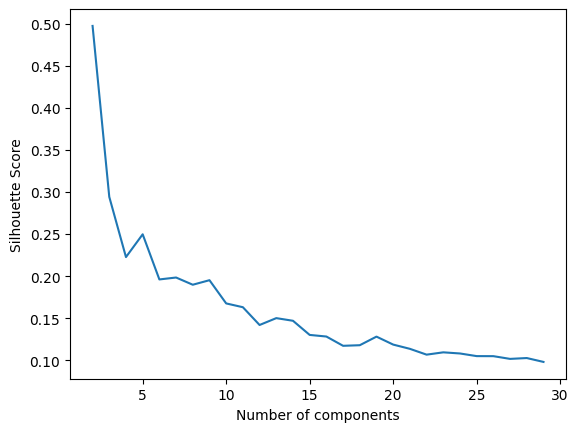

In [26]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for n_components in range(2, size):  # Start from 2 because silhouette score requires at least 2 clusters
    gmm = GaussianMixture(n_components=n_components)
    labels = gmm.fit_predict(z_np)
    silhouette_scores.append(silhouette_score(z_np, labels))

# Plot Silhouette Score
plt.plot(range(2, size), silhouette_scores)
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.show()

Kmeans inertia for k = 1 : 7368.83203125
Kmeans inertia for k = 2 : 2887.81103515625
Kmeans inertia for k = 3 : 2139.0087890625
Kmeans inertia for k = 4 : 1875.812255859375
Kmeans inertia for k = 5 : 1518.637939453125
Kmeans inertia for k = 6 : 1382.625732421875
Kmeans inertia for k = 7 : 1272.8529052734375
Kmeans inertia for k = 8 : 1144.3829345703125
Kmeans inertia for k = 9 : 1089.0177001953125
Kmeans inertia for k = 10 : 1029.773193359375
Kmeans inertia for k = 11 : 996.989990234375
Kmeans inertia for k = 12 : 962.79638671875
Kmeans inertia for k = 13 : 935.1007080078125
Kmeans inertia for k = 14 : 904.6180419921875
Kmeans inertia for k = 15 : 881.4188842773438
Kmeans inertia for k = 16 : 864.3990478515625
Kmeans inertia for k = 17 : 856.2338256835938
Kmeans inertia for k = 18 : 844.811767578125
Kmeans inertia for k = 19 : 820.65625
Kmeans inertia for k = 20 : 812.081298828125
Kmeans inertia for k = 21 : 797.076904296875
Kmeans inertia for k = 22 : 788.7786865234375
Kmeans inertia 

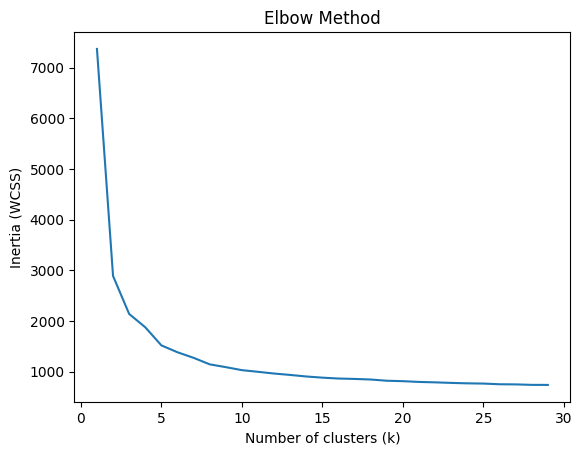

In [27]:
inertia = []

for k in range(1, size):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(z_np)
    inertia.append(kmeans.inertia_)
    print("Kmeans inertia for k =", k, ":", kmeans.inertia_)

plt.plot(range(1, size), inertia)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.show()

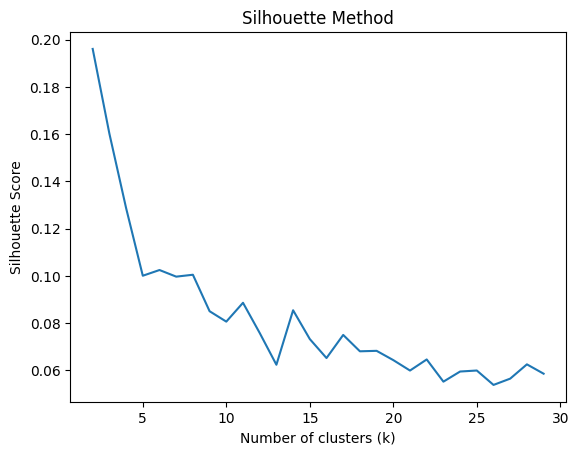

In [15]:
sil_scores = []

for k in range(2, size):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(z_np)
    sil_scores.append(silhouette_score(z_np, labels))

plt.plot(range(2, size), sil_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(z_np)

k = 5  
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances to get the elbow
distances = np.sort(distances[:, k-1])
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.grid(True)
plt.show()